### 1 - Imports

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

### 2 - Defining Skill Catalog

In [11]:
# Load skill and effects data
with open("../Ambient Data/skill_and_effects.yaml", "r", encoding="utf-8") as file:
    skill_and_effects_data = yaml.safe_load(file)

SKILL_CATALOG = skill_and_effects_data["skill_catalog"]
EFFECT_RULESET = skill_and_effects_data["effect_ruleset"]
BASE_SKILL_POINTS = skill_and_effects_data["base_skill_points"]
CD_MULTIPLIERS = skill_and_effects_data["cd_multipliers"]
EFFECT_COSTS = skill_and_effects_data["effect_costs"]

# Load equipment catalog data
with open("../Ambient Data/equipment_catalog.yaml", "r", encoding="utf-8") as file:
    equipment_catalog_data = yaml.safe_load(file)

EQUIPMENT_CATALOG = equipment_catalog_data["equipment_catalog"]

# Load enemies and events data
with open("../Ambient Data/enemies_and_events.yaml", "r", encoding="utf-8") as file:
    enemies_and_events_data = yaml.safe_load(file)

ENEMIES_CATALOG = enemies_and_events_data["pools"]["enemies"]

### 4 - Defining Skill Catalog

In [12]:
def calculate_skill_power(skill_info):
    """Calculates the total Skill Points (SP) cost of a skill."""
    
    damage_cost = skill_info['damage']  # Base cost: 1 SP per damage point
    
    effect_cost = 0
    for tag in skill_info['tags']:
        effect_cost += EFFECT_COSTS.get(tag, 0)

    # Total impact is the sum of damage and effects
    total_impact = damage_cost + effect_cost
    
    # Apply cooldown "discount"
    cd_multiplier = CD_MULTIPLIERS.get(skill_info['cd'], 0.1)  # Default low value for high CDs
    
    final_power = total_impact * cd_multiplier
    
    return final_power

### 5 - Skill Power Analysis

In [13]:
def analyze_static_power(catalog):
    """Creates a DataFrame analyzing the power of each skill in the catalog."""
    
    analysis_data = []
    for name, info in catalog.items():
        power = calculate_skill_power(info)
        info['name'] = name
        info['calculated_power'] = power
        # Calculates how much the skill deviates from the base value
        info['deviation_%'] = ((power / BASE_SKILL_POINTS) - 1) * 100
        analysis_data.append(info)
        
    df_analysis = pd.DataFrame(analysis_data)
    df_analysis = df_analysis[['name', 'damage', 'cd', 'tags', 'calculated_power', 'deviation_%']]
    
    return df_analysis.sort_values(by='calculated_power', ascending=False)


# Running static analysis
df_skill_power = analyze_static_power(SKILL_CATALOG)

print("Static Power Analysis of Skills")
from IPython.display import display
display(df_skill_power)

Static Power Analysis of Skills


,name,damage,cd,tags,calculated_power,deviation_%
17,Blade of Chaos,20,2,"[Damage, Debuff, Vulnerable]",20.4,104.0
12,Thunder Clap,15,2,"[Damage, Stun]",18.0,80.0
11,Shield Bash,8,2,"[Damage, Stun]",13.8,38.0
4,Shadow Strike,25,3,"[Damage, Physical, Stealth]",12.4,24.0
2,Heavy Blow,25,3,"[Damage, Physical]",10.0,0.0
1,Quick Strike,10,1,"[Damage, Physical]",10.0,0.0
3,Wind Slash,12,2,"[Damage, Physical, Knockback]",9.6,-4.0
14,Ice Spike,18,3,"[Damage, Slow]",9.2,-8.0
13,Frostbite,10,2,"[Damage, Slow]",9.0,-10.0
22,Fireball,15,2,"[Damage, DoT]",9.0,-10.0


### 6 - Combat Simulation Function

In [14]:
def initialize_combatant(name, hp, equipment, skills, team):
    """Função auxiliar para preparar a 'ficha de personagem' de um combatente."""
    combatant = {
        'name': name, 'hp': hp, 'max_hp': hp, 'team': team,
        'skills': {name: SKILL_CATALOG[name] for name in skills},
        'equipment': {name: EQUIPMENT_CATALOG[name] for name in equipment},
        'cooldowns': {s: 0 for s in skills},
        'effects': {},
        # Modificadores base que serão alterados pelos itens
        'damage_modifier': 1.0, 'flat_damage_bonus': 0, 'damage_reduction': 0.0,
        'crit_chance': 0.0, 'dot_potency_modifier': 1.0, 'on_hit_effects': [],
        'on_being_hit_effects': [], 'special_effects': {}
    }
    # Aplica os bônus passivos dos itens
    for item_info in combatant['equipment'].values():
        for effect, value in item_info.get('passive_effects', {}).items():
            if effect == 'flat_hp_bonus':
                combatant['hp'] += value
                combatant['max_hp'] += value
            elif effect == 'damage_modifier':
                combatant['damage_modifier'] += value
            elif effect == 'flat_damage_bonus':
                combatant['flat_damage_bonus'] += value
            elif effect == 'damage_reduction':
                combatant['damage_reduction'] += value
            elif effect == 'crit_chance':
                combatant['crit_chance'] += value
            elif effect == 'dot_potency_modifier':
                combatant['dot_potency_modifier'] += value

        if 'on_hit_effect' in item_info:
            combatant['on_hit_effects'].append(item_info['on_hit_effect'])
        if 'on_being_hit_effect' in item_info:
            combatant['on_being_hit_effects'].append(item_info['on_being_hit_effect'])
        if 'special_effect' in item_info and item_info['special_effect'] == 'Revive':
            combatant['special_effects']['Revive'] = {'used': False, 'potency': EFFECT_RULESET['Revive']['potency']}
    return combatant


def simulate_combat(combatants_setup: dict):
    """
    Simula um combate com N combatentes divididos em equipes.
    Retorna uma tupla: (número de turnos, ID da equipe vencedora).
    """
    # --- 1. SETUP INICIAL ---
    combatants = {
        name: initialize_combatant(
            name=name,
            hp=data['hp'],
            equipment=data['equipment'],
            skills=data['skills'],
            team=data['team']
    )
    for name, data in combatants_setup.items()
    }
    
    turn = 0
    max_turns = 200

    # --- 2. LOOP DE COMBATE ---
    while turn < max_turns:
        turn += 1
        
        # Cria a fila de turnos com todos os combatentes que ainda estão vivos
        turn_queue = [c for c in combatants.values() if c['hp'] > 0]
        
        for attacker in turn_queue:
            # Thiago estava certo: esta verificação é redundante, pois a turn_queue já filtra.
            # if attacker['hp'] <= 0: continue

            # --- FASE DE INÍCIO DE TURNO ---
            active_effects = list(attacker['effects'].keys())
            is_stunned = False
            for effect_name in active_effects:
                if effect_name not in attacker['effects']: continue
                
                rule = EFFECT_RULESET.get(effect_name, {})
                if rule.get('type') == 'DoT':
                    dot_damage = rule.get('damage_per_turn', 0) * attacker.get('dot_potency_modifier', 1.0)
                    attacker['hp'] -= dot_damage
                if rule.get('type') == 'Control' and effect_name in ['Stun', 'Fear']:
                    is_stunned = True
                
                attacker['effects'][effect_name]['duration'] -= 1
                if attacker['effects'][effect_name]['duration'] <= 0:
                    del attacker['effects'][effect_name]
            
            # Verifica se o atacante morreu de DoT antes de agir
            if attacker['hp'] <= 0:
                # Lógica de Revive movida para o momento exato da "morte"
                if attacker['special_effects'].get('Revive', {}).get('used') == False:
                    revive_rule = attacker['special_effects']['Revive']
                    attacker['hp'] = attacker['max_hp'] * revive_rule['potency']
                    attacker['special_effects']['Revive']['used'] = True # CORREÇÃO: Modifica o dicionário original
                else:
                    continue # Continua para o próximo atacante se já reviveu ou não tem revive

            if is_stunned: continue

            # --- FASE DE AÇÃO ---
            # SUGESTÃO DE THIAGO: Lógica de 'Wait' simplificada
            available_actions = [s for s, cd in attacker['cooldowns'].items() if cd == 0] + ['Wait']
            action_name = np.random.choice(available_actions)

            if action_name != 'Wait':
                skill_info = attacker['skills'][action_name]
                
                potential_targets = [d for d in combatants.values() if d['hp'] > 0 and d['team'] != attacker['team']]
                if not potential_targets: continue

                is_aoe = 'AOE' in skill_info['tags']
                targets = potential_targets if is_aoe else [np.random.choice(potential_targets)]

                for defender in targets:
                    if defender['hp'] <= 0: continue
                    
                    # (Cálculo de dano completo e aplicação de efeitos permanece aqui)
                    base_damage = skill_info.get('damage', 0)
                    effect_damage_mod = 1.0 + attacker['effects'].get('Buff_Self_Damage', {}).get('stat_modifier', {}).get('damage_output', 0.0)
                    effect_defense_mod = 1.0 + defender['effects'].get('Vulnerable', {}).get('stat_modifier', {}).get('defense_taken', 0.0)
                    item_damage_mod = attacker.get('damage_modifier', 1.0)
                    item_defense_mod = 1.0 - defender.get('damage_reduction', 0.0)
                    is_crit = np.random.rand() < attacker.get('crit_chance', 0.0)
                    crit_modifier = 2.0 if is_crit else 1.0
                    final_damage = (base_damage + attacker.get('flat_damage_bonus', 0)) * item_damage_mod * effect_damage_mod * crit_modifier
                    final_damage_taken = final_damage * item_defense_mod * effect_defense_mod

                    # --- APLICAÇÃO DE DANO E EFEITOS ---
                    if base_damage < 0:
                        attacker['hp'] -= base_damage # Thiago: cura o atacante. Está correto.
                    else:
                        defender['hp'] -= final_damage_taken
                        
                        # Aplica efeitos ON-HIT do atacante
                        for on_hit in attacker['on_hit_effects']:
                            if np.random.rand() < on_hit['chance']:
                                tag = on_hit['effect_tag']
                                if tag in EFFECT_RULESET:
                                    defender['effects'][tag] = {'duration': EFFECT_RULESET[tag]['duration']}
                        
                        # Aplica efeitos ON-BEING-HIT do defensor
                        if defender['hp'] > 0:
                            for on_being_hit in defender['on_being_hit_effects']:
                                if np.random.rand() < on_being_hit['chance']:
                                    tag = on_being_hit['effect_tag']
                                    if tag == 'Reflect':
                                        attacker['hp'] -= final_damage_taken * EFFECT_RULESET['Reflect']['potency']
                                    elif tag in EFFECT_RULESET:
                                        attacker['effects'][tag] = {'duration': EFFECT_RULESET[tag]['duration']}

                    # Aplica efeitos da skill usada
                    for tag in skill_info['tags']:
                        if tag in EFFECT_RULESET:
                            rule = EFFECT_RULESET[tag]
                            target = attacker if rule.get('target') == 'Self' else defender
                            target['effects'][tag] = {'duration': rule['duration']}
                    
                    attacker['cooldowns'][action_name] = skill_info['cd']

                    # Verifica se o defensor morreu e aplica Revive
                    if defender['hp'] <= 0:
                        if defender['special_effects'].get('Revive', {}).get('used') == False:
                            revive_rule = defender['special_effects']['Revive']
                            defender['hp'] = defender['max_hp'] * revive_rule['potency']
                            defender['special_effects']['Revive']['used'] = True

            # --- FIM DO TURNO DO ATACANTE ---
            for skill in attacker['cooldowns']:
                if attacker['cooldowns'][skill] > 0:
                    attacker['cooldowns'][skill] -= 1

        # --- FIM DA RODADA: Verificação de Fim de Combate ---
        teams_alive = {c['team'] for c in combatants.values() if c['hp'] > 0}
        
        if len(teams_alive) <= 1:
            winner_team = teams_alive.pop() if teams_alive else None
            # CORREÇÃO: Retorna o ID da equipe, não um valor fixo
            return (turn, winner_team)
            
    return (turn, None) # Empate

### 7 - Simulation Result

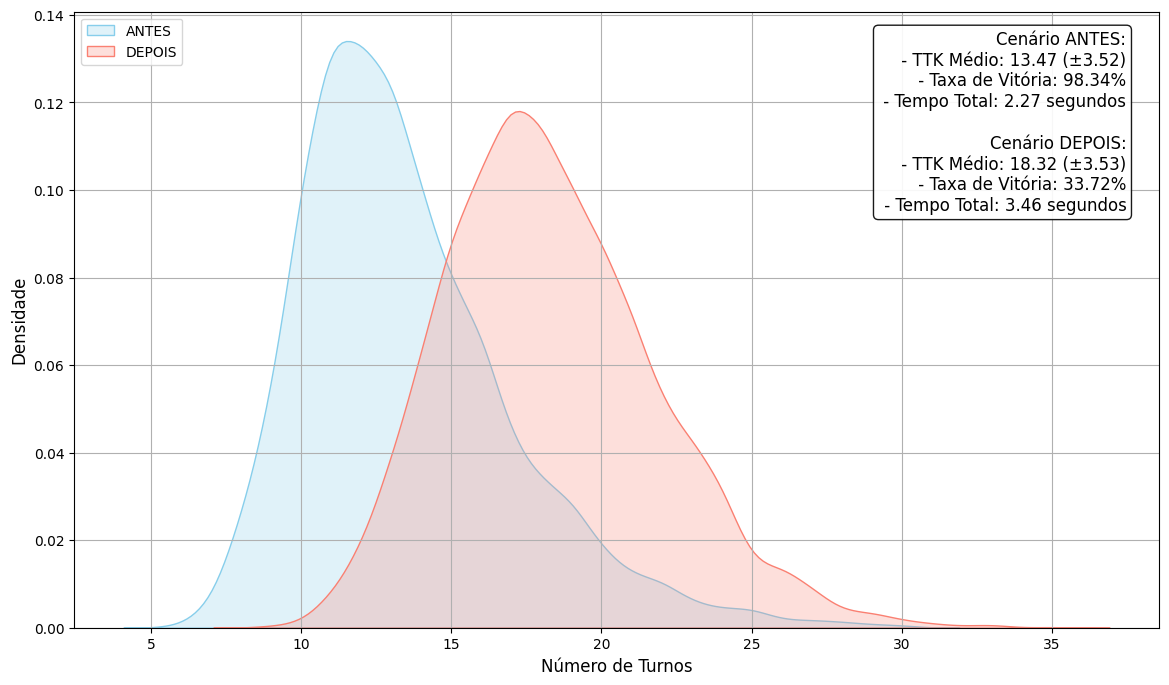

In [27]:
# Running the realistic simulations
n_simulations = 5000

# Equipamento e habilidades do agente antes e depois da mudança
agent_before = {
    'name': 'Agent 1',
    'hp': 25,
    'equipment': ['Shortsword', 'Leather Tunic', 'Tome of Haste'],
    'skills': ['Quick Strike', 'Heavy Blow', 'Stone Shield', 'Wait'],
    'team': 1
}

agent_after = {
    'name': 'Agent 2',
    'hp': 25,
    'equipment': ['Blade of the Martyr', 'Bulwark of the Saint', 'Poisoner\'s Talisman'],
    'skills': ['Quick Strike', 'Heavy Blow', 'Stone Shield', 'Wait'],
    'team': 1
}

adversarial_agent = {
    'name': 'Agent 3',
    'hp': 80,
    'equipment': ['Blade of the Martyr', 'Bulwark of the Saint', 'Poisoner\'s Talisman'],
    'skills': ['Quick Strike', 'Heavy Blow', 'Stone Shield', 'Wait'],
    'team': 2
}

# Popula o dicionário de combatentes
combatants = {}
enemy_name = ['Cursed Knight', 'Poisoned Scorpion']

for name in enemy_name:
    data = ENEMIES_CATALOG.get(name, {})
    if data:
        combatants[name] = {
            'name': name,
            'hp': data['hp'],
            'equipment': data['equipment'],
            'skills': data['skills'],
            'team': -1  # Define o time do inimigo como -1                        
        }
        
# combatants_before = {'Agent': agent_before, **combatants}
# combatants_after = {'Agent': agent_after, **combatants}

# combatants_before = {'Agent 1': agent_before, **combatants}
combatants_before = {'Agent 1': agent_before, 'Agent 2': agent_after, **combatants}
combatants_after = {'Agent 1': agent_before, 'Agent 2': agent_after, 'Agent 3': adversarial_agent, **combatants}

import time  # <-- Adicione esta linha no início do seu script

# Medindo tempo para simulações "antes"
start_before = time.time()
results_before = [simulate_combat(combatants_before) for _ in range(n_simulations)]
end_before = time.time()
duration_before = end_before - start_before

# Medindo tempo para simulações "depois"
start_after = time.time()
results_after = [simulate_combat(combatants_after) for _ in range(n_simulations)]
end_after = time.time()
duration_after = end_after - start_after

# Processa os resultados
ttk_before = [r[0] for r in results_before]
wins_before = sum(1 for r in results_before if r[1] == 1)
win_rate_before = (wins_before / n_simulations) * 100

ttk_after = [r[0] for r in results_after]
wins_after = sum(1 for r in results_after if r[1] == 1)
win_rate_after = (wins_after / n_simulations) * 100

# Criar o gráfico com KDE das distribuições
plt.figure(figsize=(14, 8))
sns.kdeplot(ttk_before, label='ANTES', color='skyblue', fill=True, warn_singular=False)
sns.kdeplot(ttk_after, label='DEPOIS', color='salmon', fill=True, warn_singular=False)
#plt.title(f'TTK {combatants_after['Agent']['name']} (HP = {combatants_after['Agent']['hp']}) VS {combatants_after[enemy_name]['name']} (HP = {combatants_after[enemy_name]['hp']})', fontsize=16)
plt.xlabel('Número de Turnos', fontsize=12)
plt.ylabel('Densidade', fontsize=12)
plt.legend()
plt.grid(True)

# Adiciona os textos com informações de TTK e Win Rate
textstr = (
    f"Cenário ANTES:\n"
    f" - TTK Médio: {np.mean(ttk_before):.2f} (±{np.std(ttk_before):.2f})\n"
    f" - Taxa de Vitória: {win_rate_before:.2f}%\n"
    f" - Tempo Total: {duration_before:.2f} segundos\n\n"
    f"Cenário DEPOIS:\n"
    f" - TTK Médio: {np.mean(ttk_after):.2f} (±{np.std(ttk_after):.2f})\n"
    f" - Taxa de Vitória: {win_rate_after:.2f}%\n"
    f" - Tempo Total: {duration_after:.2f} segundos"
)

# Define as propriedades da caixa de texto
props = dict(boxstyle='round', facecolor='white', alpha=0.9)

# Posiciona no canto superior direito (x=0.97, y=0.97 no sistema de coordenadas Axes)
plt.gca().text(0.97, 0.97, textstr, transform=plt.gca().transAxes,
               fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=props)

plt.show()


### 8 - Stress test (1v1v1 - 10v10v10)

In [30]:
import time
import numpy as np
import random
import csv

# --- Configuração global ---
random.seed(42)
np.random.seed(42)

n_simulations = 100000
teams = [1, 2, 3]  # Três times distintos

# Templates de combatentes
agent_template = {
    'hp': 150,
    'equipment': ['Battle Axe', 'Steel Plate', 'Pendant of Will'],
    'skills': ['Heavy Blow', 'Stone Shield', 'Thunder Clap', 'Wait']
}

enemy_template = {
    'hp': 130,
    'equipment': ['Iron Sword', 'Chain Shirt', 'Amulet of Vigor'],
    'skills': ['Quick Strike', 'War Cry','Berserker Rage', 'Wait']
}

# Arquivo CSV para resultados
csv_filename = "scaling_results100k.csv"
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Combatentes_por_Time', 'Total_Combatentes', 'Simulacoes', 'Tempo_Total_s', 'Tempo_Medio_ms', 'Combates_por_Segundo'])

    # Loop para 1v1v1 até 10v10v10
    for num_per_team in range(1, 11):
        # --- Geração dinâmica do cenário ---
        combatants_setup = {}
        for team_id in teams:
            for i in range(num_per_team):
                if team_id == 1:
                    name = f'Agent_Team1_{i+1}'
                    combatant_data = agent_template.copy()
                elif team_id == 2:
                    name = f'Enemy_Team2_{i+1}'
                    combatant_data = enemy_template.copy()
                else:
                    name = f'Adversary_Team3_{i+1}'
                    combatant_data = agent_template.copy()

                combatant_data['team'] = team_id
                combatants_setup[name] = combatant_data

        # --- Execução das simulações ---
        start_time = time.time()
        for _ in range(n_simulations):
            simulate_combat(combatants_setup)
        end_time = time.time()

        total_duration = end_time - start_time
        avg_time_ms = (total_duration / n_simulations) * 1000
        combats_per_sec = n_simulations / total_duration if total_duration > 0 else float('inf')
        total_units = len(combatants_setup)

        # --- Impressão dos resultados ---
        print(f"\n== Cenário {num_per_team}v{num_per_team}v{num_per_team} ({total_units} total) ==")
        print(f"Tempo total: {total_duration:.2f} s | Tempo médio: {avg_time_ms:.2f} ms | Combates/s: {combats_per_sec:.2f}")

        # --- Gravação no CSV ---
        writer.writerow([num_per_team, total_units, n_simulations, round(total_duration, 3), round(avg_time_ms, 3), round(combats_per_sec, 2)])

print(f"\nTodos os resultados foram salvos em '{csv_filename}'.")



== Cenário 1v1v1 (3 total) ==
Tempo total: 90.39 s | Tempo médio: 0.90 ms | Combates/s: 1106.26

== Cenário 2v2v2 (6 total) ==
Tempo total: 180.22 s | Tempo médio: 1.80 ms | Combates/s: 554.89

== Cenário 3v3v3 (9 total) ==
Tempo total: 278.09 s | Tempo médio: 2.78 ms | Combates/s: 359.60

== Cenário 4v4v4 (12 total) ==
Tempo total: 372.06 s | Tempo médio: 3.72 ms | Combates/s: 268.77

== Cenário 5v5v5 (15 total) ==
Tempo total: 475.48 s | Tempo médio: 4.75 ms | Combates/s: 210.31

== Cenário 6v6v6 (18 total) ==
Tempo total: 587.34 s | Tempo médio: 5.87 ms | Combates/s: 170.26

== Cenário 7v7v7 (21 total) ==
Tempo total: 673.68 s | Tempo médio: 6.74 ms | Combates/s: 148.44

== Cenário 8v8v8 (24 total) ==
Tempo total: 779.88 s | Tempo médio: 7.80 ms | Combates/s: 128.23

== Cenário 9v9v9 (27 total) ==
Tempo total: 892.81 s | Tempo médio: 8.93 ms | Combates/s: 112.01

== Cenário 10v10v10 (30 total) ==
Tempo total: 1001.50 s | Tempo médio: 10.02 ms | Combates/s: 99.85

Todos os resultado